In [1]:

import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats

from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import torch.nn.functional as F


from utility import CityscapeSegTemp, get_min_max, train, evaluate, plot_samples, plot_predictions, plot_metrics

from utility import cityscapes_cmap, plot_class_colors


import multiprocessing as mp

mp.set_start_method('spawn', force=True)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)  
elif torch.backends.mps.is_available():  # Check for M1 GPU availability
    device = torch.device("mps")  # M1 GPU
    gpu_name = "Apple M1"
else:
    device = torch.device("cpu")
    gpu_name = "CPU"

print(f"Using device: {device}, GPU: {gpu_name}")

Using device: cuda, GPU: NVIDIA GeForce RTX 4090


In [3]:
# temp_min, temp_max = get_min_max('./data')

temp_min, temp_max = 13.5, 44.5 # get_min_max will give this value, manually defined just to make it faster

print(temp_min, temp_max)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

13.5 44.5


In [9]:
aug = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



val_dataset =   CityscapeSegTemp(root_dir = './data', split= 'val', 
                                 transform = aug,
                                #  temp_scale=(temp_min, temp_max)
                                 )


batch_size = 32


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers = 16)


In [5]:
unique_mask_values = set()

for i in range(20):
    _, (mask, _) = val_dataset[i]  # Assuming this is how your dataset returns values
    unique_values = torch.unique(mask).tolist()  # Convert to a list of values
    unique_mask_values.update(unique_values)  # Update the set with new unique values

print(f'Unique mask values in the dataset: {unique_mask_values}')
print(f'Total: {len(unique_mask_values)}')

Unique mask values in the dataset: {0, 1, 2, 3, 4, 5, 6}
Total: 7


In [6]:
from blocks import Bottleneck, ASPP, UpsampleBlock, ResidualBlock

class ResidualUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResidualUNet, self).__init__()
        
        self.encoder1 = self._make_layer(3, 64, 1)    
        self.encoder2 = self._make_layer(64, 128, 3, stride =2) # 1/2
        self.encoder3 = self._make_layer(128, 256, 4, stride=2) # 1/4
        self.encoder4 = self._make_layer(256, 512, 6, stride=2) # 1/8
        self.encoder5 = self._make_layer(512, 1024, 3)          # 1/16 

        self.aspp_mask = ASPP(1024, 1024, [6, 12, 18])
       
        self.upsample1 = UpsampleBlock(1024, 512)
        self.upsample2 = UpsampleBlock(512, 256)
        self.upsample3 = UpsampleBlock(256, 128)
        self.upsample4 = UpsampleBlock(128, 64)

        self.mask_output = nn.Sequential(
            
            nn.Conv2d(64, num_classes, kernel_size=1)
        ) 

        self.temp_output = nn.Sequential(

            ResidualBlock(1024, 2048, stride=2), # 4x2
            nn.Dropout2d(0.3),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 , 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Dropout(0.7),
            nn.Linear(4096 , 1)
        )
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        expansion = Bottleneck.expansion

        if stride != 1 or in_channels != out_channels * expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * expansion),
            )

        layers = [Bottleneck(in_channels, out_channels, stride, downsample)]

        in_channels = out_channels * expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(in_channels, out_channels))
        
        layers.append( nn.Dropout2d(p=0.3))
        return nn.Sequential(*layers)


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1) # 1/2
        enc3 = self.encoder3(enc2) # 1/4
        enc4 = self.encoder4(enc3) # 1/8
        enc5 = self.encoder5(enc4) # 1/16

        aspp_mask = self.aspp_mask(enc5)
    
        up1 = self.upsample1(aspp_mask, enc4)
        up2 = self.upsample2(up1, enc3)
        up3 = self.upsample3(up2, enc2)
        up4 = self.upsample4(up3, enc1)

        mask = self.mask_output(up4)
        temp = self.temp_output(aspp_mask) 

        return mask, temp

In [11]:
num_classes = len(unique_mask_values)

In [7]:
model = ResidualUNet(len(unique_mask_values))
model = model.to(device)
model.load_state_dict(torch.load('VisTemp.pth'))

<All keys matched successfully>

## Evaluate Validation data

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4b1fcf44c0>
Traceback (most recent call last):
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/varinaldi/miniconda3/envs/torchomp/lib/python3.10/

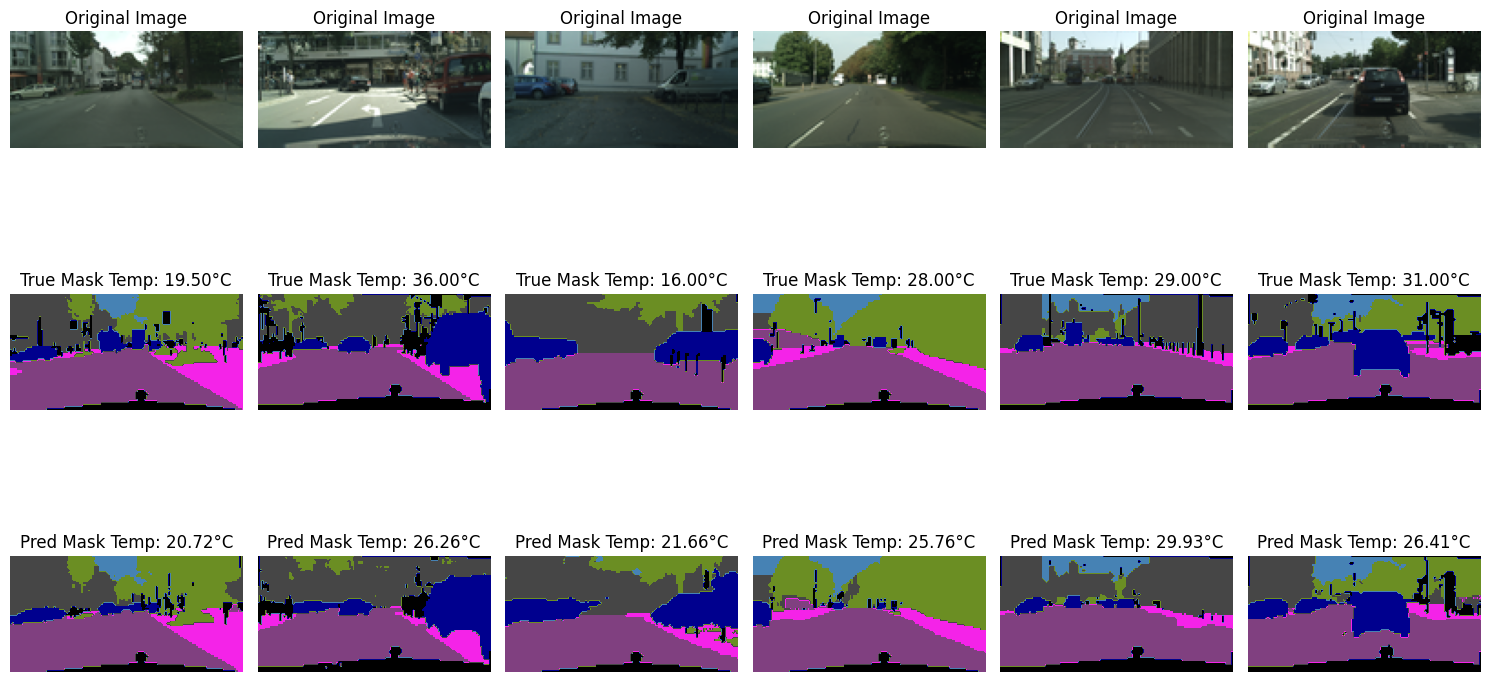

In [10]:
plot_predictions(model, val_loader, device, num_samples=6,  unnormalize= True, mean = mean , std = std, 
                #  temp_scale=(temp_min, temp_max)
                 )

In [39]:


def plot_metrics(model, data_loader, device, num_classes, temp_scale= None):
    all_preds = []
    all_trues = []
    true_temps = []
    pred_temps = []
    
    model.eval()
    with torch.no_grad():
        for images, (masks, temperatures) in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            temperatures = temperatures.to(device)

            output_masks, output_temps = model(images)
            preds = output_masks.argmax(dim=1).cpu().numpy()
            temps = output_temps.squeeze().cpu().numpy()

            if temp_scale is not None:
                temp_min, temp_max = temp_scale
                temperatures = unscale_temp(temperatures, temp_min, temp_max)
                temps = unscale_temp(temps, temp_min, temp_max)

            all_trues.extend(masks.cpu().numpy().flatten())
            all_preds.extend(preds.flatten())
            true_temps.extend(temperatures.cpu().numpy())
            pred_temps.extend(temps)

    # Compute the confusion matrix
    cm = confusion_matrix(all_trues, all_preds, labels=list(range(num_classes)))

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Fit a line to the scatter plot data
    slope, intercept, r_value, _, _ = stats.linregress(true_temps, pred_temps)
    line_fit = [slope * x + intercept for x in true_temps]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))

    # Confusion Matrix
    
    sns.set(font_scale=1.3)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='magma', ax=axs[0], xticklabels=True, yticklabels=True)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_title('Normalized Confusion Matrix')

   

    # Scatter Plot with Line Fit and R²
    axs[1].scatter(true_temps, pred_temps, alpha=0.5)
    axs[1].plot(true_temps, line_fit, 'r')
    axs[1].set_xlabel('True Temperatures')
    axs[1].set_ylabel('Predicted Temperatures')
    axs[1].set_title(f'True vs Predicted Temperatures (R²: {r_value**2:.2f})')

    plt.tight_layout()
    plt.show()

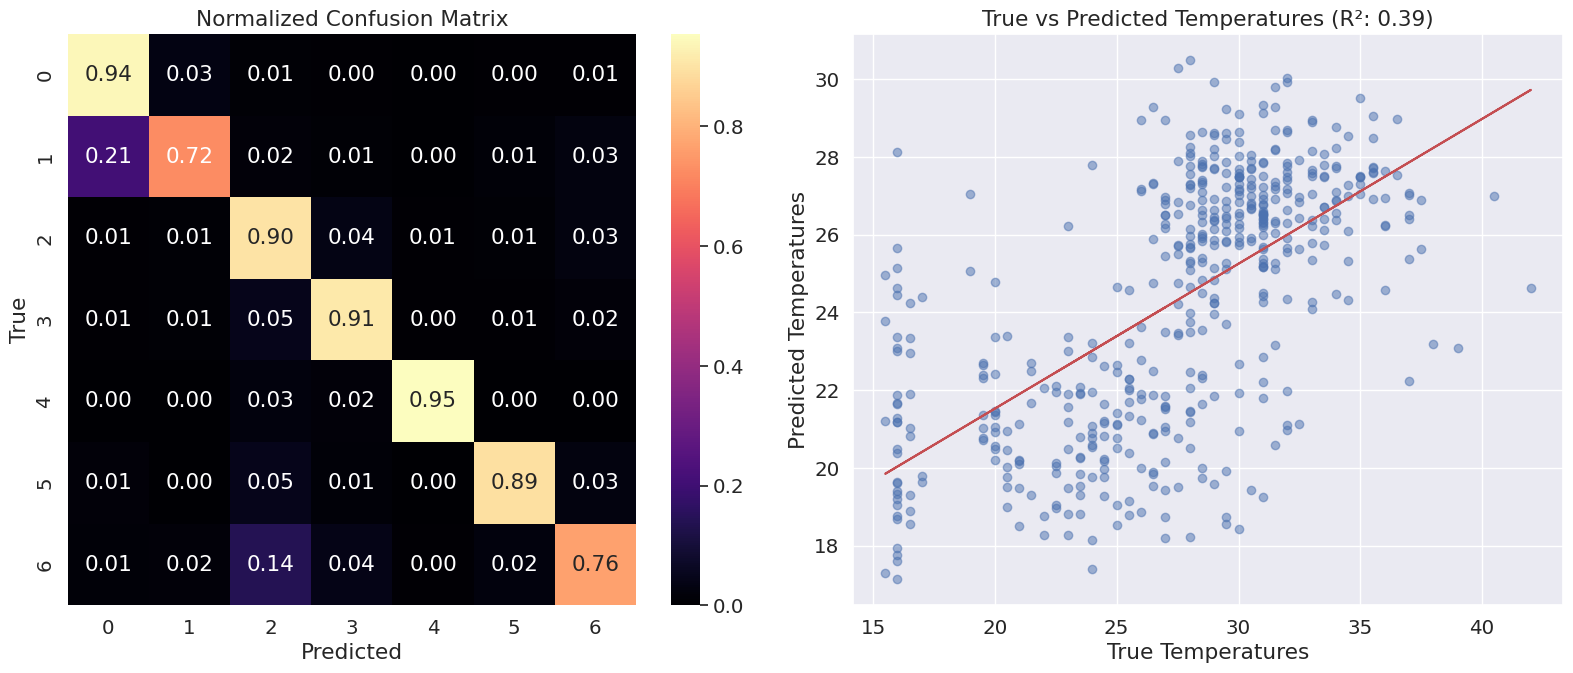

In [40]:
plot_metrics(model, val_loader, device, num_classes, 
            #  temp_scale=(temp_min, temp_max)
             )